In [130]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import numpy as np
import scipy.stats as sst
from scikit_posthocs import posthoc_dunn
import scipy.signal as snl
from statsmodels.formula.api import ols, quantreg
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, display

from nems import db as nd
from nems_lbhb.baphy_experiment import BAPHYExperiment

from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts
from src.data.cell_type import get_phototags, get_waveform_metrics
from src.root_path import config_path, root_path


config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


##### This notebook contains PAPER FIGURES!!!
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)


In [131]:
# quick and dirty, get the celltype dataframe, merge to main DF and run categorical linear regressions
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
type_DF = jl.load(type_DF_file)
type_DF = type_DF.loc[:, ['id', 'spike_type', 'phototag']]
type_DF.dropna(subset=['spike_type', 'phototag'], how='all')
type_DF.head()

,id,spike_type,phototag
0,TNC015a-25-3,broad,s
1,TNC016a-31-1,broad,s
2,ley075b-17-1,narrow,NaN
3,TNC023a-036-1,broad,s
4,TNC045a-021-1,narrow,a


In [132]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91812, 9)


,id,context_pair,probe,value,metric,site,region,diff_metric,trans_pair
0,ley070a-37-1,00_01,1,166.028305,integral,ley070a,A1,delta_FR,same_silence
1,ley070a-42-1,00_01,1,223.114288,integral,ley070a,A1,delta_FR,same_silence
2,ley070a-04-1,00_02,1,326.940277,integral,ley070a,A1,delta_FR,diff_silence
3,ley070a-10-1,00_02,1,251.927353,integral,ley070a,A1,delta_FR,diff_silence
4,ley070a-12-3,00_02,1,359.384583,integral,ley070a,A1,delta_FR,diff_silence


In [133]:
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress, type_DF, on='id', validate="m:1")

# the simplest approach is to manually map the 4 categories into onehots
# onehot order: diff same silence
mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}
toregress['onehot'] = toregress['trans_pair'].replace(mapper)

onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
toregress = pd.concat([toregress, onehotdf], axis=1)

toregress.drop(columns='onehot', inplace=True)
del(onehotdf)
print(toregress.shape)
toregress.head()

(89824, 16)


,id,context_pair,probe,value,metric,site,region,diff_metric,trans_pair,grand_mean,norm_val,spike_type,phototag,diff,same,silence
0,ARM018a-31-1,00_01,1,239.917480,integral,ARM018a,PEG,delta_FR,same_silence,236.451141,1.014660,broad,NaN,0,1,1
1,ARM018a-31-1,00_03,1,591.796448,integral,ARM018a,PEG,delta_FR,diff_silence,236.451141,2.502828,broad,NaN,1,0,1
2,ARM018a-31-1,00_04,1,410.525452,integral,ARM018a,PEG,delta_FR,diff_silence,236.451141,1.736196,broad,NaN,1,0,1
3,ARM018a-31-1,01_02,1,143.950485,integral,ARM018a,PEG,delta_FR,diff_same,236.451141,0.608796,broad,NaN,1,1,0
4,ARM018a-31-1,01_04,1,117.292992,integral,ARM018a,PEG,delta_FR,diff_same,236.451141,0.496056,broad,NaN,1,1,0


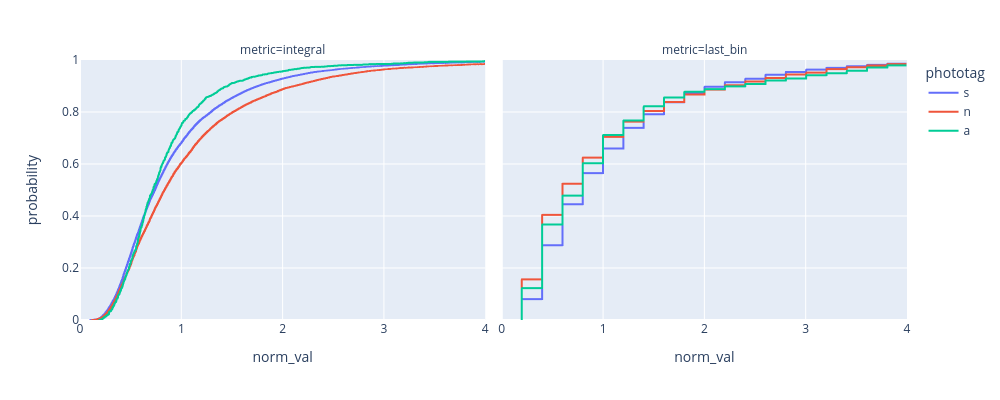

In [134]:
toplot = toregress.dropna(subset='phototag')

fig = px.ecdf(toplot, x="norm_val",  color='phototag', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [135]:
d = toregress.query("metric == 'integral'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     209.6
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           2.60e-91
Time:                        13:14:24   Log-Likelihood:                -49585.
No. Observations:               41179   AIC:                         9.918e+04
Df Residuals:                   41176   BIC:                         9.920e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8628      0.022  

In [136]:
d = toregress.query("metric == 'last_bin'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     30.03
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           9.28e-14
Time:                        13:14:24   Log-Likelihood:                -51559.
No. Observations:               41179   AIC:                         1.031e+05
Df Residuals:                   41176   BIC:                         1.031e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0127      0.023  

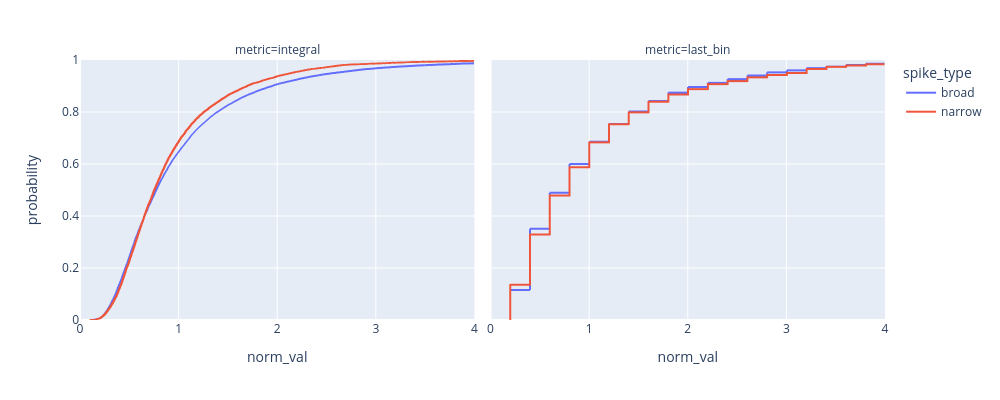

In [137]:
toplot = toregress.dropna(subset='spike_type')

fig = px.ecdf(toplot, x="norm_val",  color='spike_type', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [138]:
d = toregress.query("metric == 'last_bin'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.003
Date:                Sat, 26 Nov 2022   Prob (F-statistic):             0.0454
Time:                        13:14:30   Log-Likelihood:                -54975.
No. Observations:               44141   AIC:                         1.100e+05
Df Residuals:                   44139   BIC:                         1.100e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [139]:
d = toregress.query("metric == 'integral'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     103.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           2.34e-24
Time:                        13:14:30   Log-Likelihood:                -53109.
No. Observations:               44141   AIC:                         1.062e+05
Df Residuals:                   44139   BIC:                         1.062e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# focus on spike width
The photo tagged units are restricted to narrow waveforms, whereas they are spread across all other categories.
Let just define categories based on spike waveforms

In [140]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
toclust = jl.load(type_DF_file).dropna(subset='sw')
print(toclust.shape)
toclust['siteid'] = toclust['id'].str.split('-').str[0]

# refresh phototags
pt = get_phototags()
pt.rename(columns={'cellid': 'id'}, inplace=True)
toclust.drop(columns=['phototag'], inplace=True)
toclust = pd.merge(toclust, pt, on=['siteid','id'], validate="1:1", how='left')

# uniffied phototagg, merge suppressed and neutral. names untagged
toclust['phototag2'] = toclust['phototag'].astype(object)
toclust.phototag2.replace({'n':'n+s', 's':'n+s'},inplace=True)
toclust.loc[toclust.phototag2.isnull(),'phototag2'] = 'untagged'
toclust['phototag2'] = toclust['phototag2'].astype('category')

# just activated
toclust['phototag3'] = toclust['phototag'].astype(object)
toclust.phototag3.replace({'a':True, 'n':False, 's':False},inplace=True)
toclust.loc[toclust.phototag3.isnull(),'phototag3'] = False
toclust['phototag3'] = toclust['phototag3'].astype(bool)

#classify which neurons were injected
toclust['injected'] = ~pd.isnull(toclust.phototag)

print(toclust.shape)
print(toclust.groupby(['phototag2']).agg(cell_count=('id', 'count')))
print(toclust.groupby(['phototag3']).agg(cell_count=('id', 'count')))

(1630, 12)
(1630, 15)
           cell_count
phototag2            
a                  51
n+s               885
untagged          694
           cell_count
phototag3            
False            1579
True               51


### find clusters
by simple historgram threshold. **this is working pretty well**

waveform threshold. lower: 0.37, upper 0.47


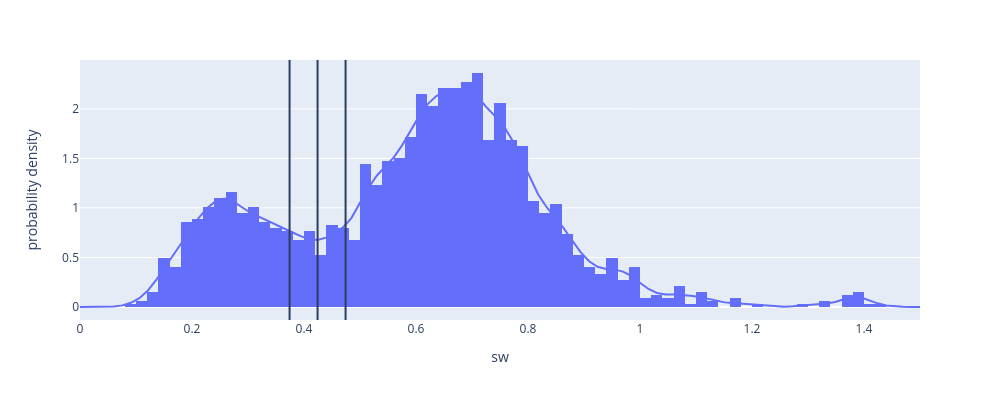

In [141]:
# define kernel density estimate, the bandwidth is defined empirically
kernel = sst.gaussian_kde(toclust.loc[~toclust.sw.isnull(), 'sw'], 0.1)
x = np.linspace(0, 1.5, 100)
hist = kernel(x)

# find valley in bimodal distribution
min_idx = snl.argrelmin(hist)[0]
# print(x[min_idx])
hist_threshold = x[min_idx[0]]
margin = 0.05 # plus or minus in ms
print(f'waveform threshold. lower: {hist_threshold-margin:.2f}, upper {hist_threshold+margin:.2f}')

# Classifies base on valley plus an unclasified zone of 0.1ms
named_labels = np.empty(len(toclust['sw']), dtype=object)
named_labels[toclust['sw'] < (hist_threshold - margin)] = 'narrow'
named_labels[np.logical_and((hist_threshold - margin) <= toclust['sw'],
                            (toclust['sw'] < (hist_threshold + margin)))] = 'unclass'
named_labels[(hist_threshold + margin) <= toclust['sw']] = 'broad'

toclust['sw_kde'] = named_labels

# plot KDE on top of histogram
KDE_line = px.line(x=x, y=hist)
fig = px.histogram(toclust, x='sw', nbins=100, histnorm='probability density')
fig.add_traces(KDE_line['data'])
fig.add_vline(x=hist_threshold)
fig.add_vline(x=hist_threshold-margin)
fig.add_vline(x=hist_threshold+margin)
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

### double classification
This should not change much, the idea is that we merge putative narrow wave with photoactivated and we call it putative inhibitory interneurons.on the oter hand we take broad spikes that are not photo activated and we classify them as putative exitatory neurons.In other words the narrow wave cluster is gaining some exited neurons, and the wide cluster is loosing some.

In [142]:

putative = np.empty(toclust.shape[0], dtype=object)
inhibitory = np.logical_or(toclust.phototag3, toclust.sw_kde == 'narrow')

pyramidal = np.logical_and(~toclust.phototag3,
                           toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3,
                         toclust.sw_kde == 'unclass')

putative[inhibitory] = 'inhibitory'
putative[pyramidal] = 'pyramidal'
putative[unclass] = 'unclass'

toclust['putative'] = pd.Series(putative, dtype='category')


### Triple classification
Focus on narrow vs broad, pulling out the third clasiffication: activated, as a confirmation of narrow

In [143]:

triple = np.empty(toclust.shape[0], dtype=object)
activated = toclust.phototag == 'a'
narrow = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'narrow')
broad = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'unclass')

triple[toclust.phototag3] = 'activated'
triple[narrow] = 'narrow'
triple[broad] = 'broad'
triple[unclass] = 'unclass'

toclust['triple'] = pd.Series(triple, dtype='category')

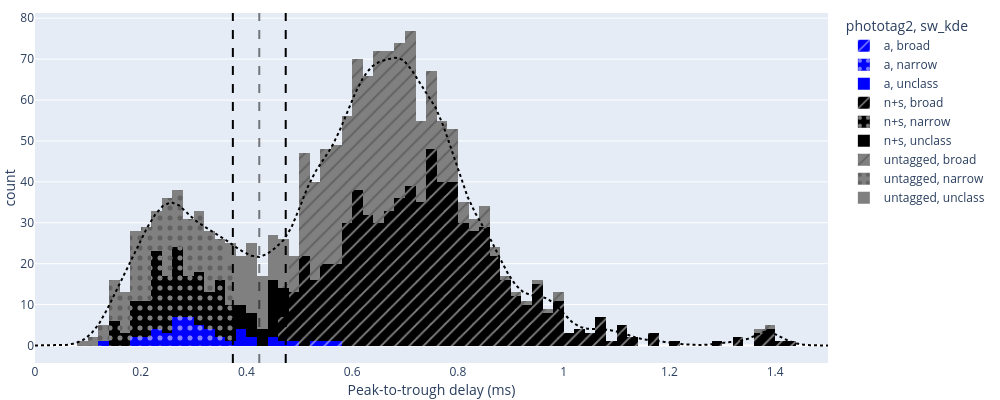

In [144]:
fig = px.histogram(toclust.dropna(subset=['phototag2']), nbins=100,
                   x='sw', color='phototag2',
                   pattern_shape='sw_kde',
                   pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
                   barmode='stack',
                   color_discrete_map={'a': HardBlue, 'n+s': "black", 'untagged':'gray'},
                   category_orders={'phototag2': ['a', 'n+s', 'untagged']},
                   )

# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='black', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash'),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash'))
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash'))

fig.update_layout(margin=dict(t=10,b=10,l=10,r=10),
                  yaxis=dict(title_standoff=0),
                  xaxis=dict(title=dict(standoff=0, text='Peak-to-trough delay (ms)')),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

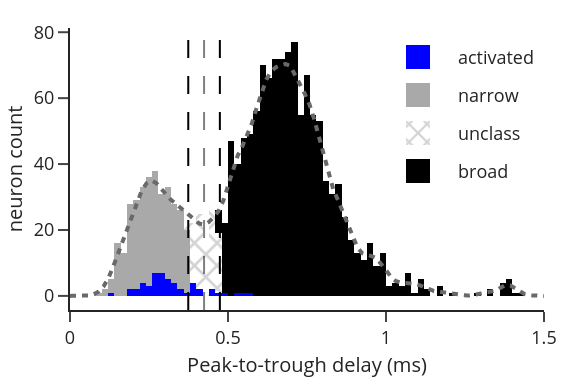

In [145]:
fig = px.histogram(toclust.dropna(subset=['triple']), nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash',width=1),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash',width=1), opacity=1)
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash',width=1), opacity=1)


w, h= 3, 2
fig.update_layout(template='simple_white',
                  width=96*w, height=96*h,
                  margin=dict(t=10,b=10,l=10,r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

filename = folder / 'fig5_cell_type_histogram'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=2)
Image(img_bytes)

In [146]:
toclust.groupby('triple').agg(count=('id', pd.Series.nunique))

,count
triple,
activated,51
broad,1172
narrow,301
unclass,106


## no injections sites
there is the fear that viral injections might damage the neurons and modify their behavior

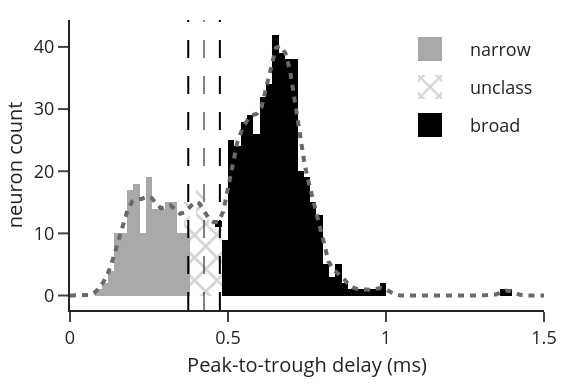

In [147]:
toplot = toclust.dropna(subset=['triple']).query('not injected')
fig = px.histogram(toplot,
                   nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toplot['sw'], 0.1)
del(toplot)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 14
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash',width=1),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash',width=1), opacity=1)
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash',width=1), opacity=1)


w, h= 3, 2
fig.update_layout(template='simple_white',
                  width=96*w, height=96*h,
                  margin=dict(t=10,b=10,l=10,r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

# filename = folder / 'fig5_cell_type_histogram_uninjected'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=2)
Image(img_bytes)

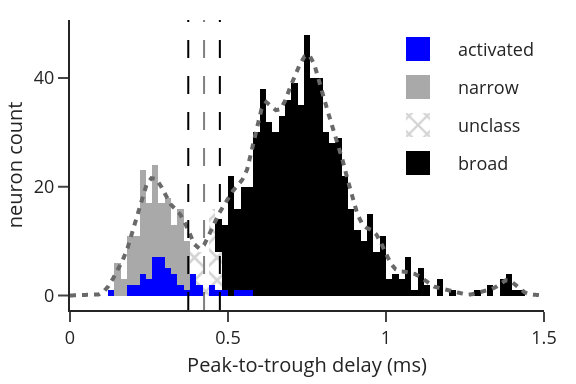

In [148]:
toplot = toclust.dropna(subset=['triple']).query('injected')
fig = px.histogram(toplot,
                   nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toplot['sw'], 0.1)
del(toplot)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 20
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash',width=1),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash',width=1), opacity=1)
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash',width=1), opacity=1)


w, h= 3, 2
fig.update_layout(template='simple_white',
                  width=96*w, height=96*h,
                  margin=dict(t=10,b=10,l=10,r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

# filename = folder / 'fig5_cell_type_histogram_injected'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=2)
Image(img_bytes)

### double classification
This should not change much, the idea is that we merge putative narrow wave with photoactivated and we call it
putative inhibitory interneurons. on the oter hand we take broad spikes that are not photo activated and we
classify them as putative exitatory neurons. In other words the narrow wave cluster is gaining some exited neurons,
and the wide cluster is loosing some.

In [149]:
putative = np.empty(toclust.shape[0], dtype=object)
inhibitory = np.logical_or(toclust.phototag3, toclust.sw_kde == 'narrow')

pyramidal = np.logical_and(~toclust.phototag3,
                           toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3,
                         toclust.sw_kde == 'unclass')


putative[inhibitory] = 'inhibitory'
putative[pyramidal] = 'pyramidal'
putative[unclass] = 'unclass'

toclust['putative'] = pd.Series(putative, dtype='category')

### Triple classification
Focus on narrow vs broad, pulling out the third clasiffication: activated, as a confirmation of narrrow

In [150]:
triple = np.empty(toclust.shape[0], dtype=object)
activated = toclust.phototag == 'a'
narrow = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'narrow')
broad = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'unclass')

triple[toclust.phototag3] = 'activated'
triple[narrow] = 'narrow'
triple[broad] = 'broad'
triple[unclass] = 'unclass'

toclust['triple'] = pd.Series(triple, dtype='category')

# mean of  waveforms for different categories

In [151]:
toclust

,id,sw,ptr,fwhm,es,bs,trough,waveform_norm,isolation,spike_type,siteid,phototag,phototag2,phototag3,injected,sw_kde,putative,triple
0,TNC015a-25-3,0.713400,0.076539,0.151973,0.076474,0.602153,4940.0,"[-0.020382194183487683, -0.02050147953168996, ...",95.0000,broad,TNC015a,s,n+s,False,True,broad,pyramidal,broad
1,TNC016a-31-1,0.652993,0.112127,0.221673,0.184742,0.298480,4935.0,"[0.009095303840524066, 0.008946538437308554, 0...",95.0000,broad,TNC016a,s,n+s,False,True,broad,pyramidal,broad
2,ley075b-17-1,0.246547,0.311942,0.216753,0.491396,0.413280,4957.0,"[-0.08923484796507959, -0.08923604620777648, -...",95.0000,narrow,ley075b,NaN,untagged,False,False,narrow,inhibitory,narrow
3,TNC023a-036-1,0.857720,0.162750,0.269233,0.159635,0.509493,4955.0,"[-0.020862116331022446, -0.020964903571808066,...",99.6497,broad,TNC023a,s,n+s,False,True,broad,pyramidal,broad
4,TNC045a-021-1,0.288367,0.253814,0.121087,0.325353,0.880133,4948.0,"[0.017260767735950887, 0.01718691714659574, 0....",95.0000,narrow,TNC045a,a,a,True,True,narrow,inhibitory,activated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,TNC016a-49-5,0.713127,0.189008,0.261307,0.168348,0.461933,4974.0,"[0.04297806078589745, 0.04356003969211265, 0.0...",100.0000,broad,TNC016a,s,n+s,False,True,broad,pyramidal,broad
1626,ARM019a-31-5,0.684700,0.147718,0.247640,0.190143,0.293833,4918.0,"[-0.1600373899959138, -0.15999724686037398, -0...",95.0000,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
1627,TNC047a-28-1,0.806060,0.200002,0.281260,0.155441,0.436240,4926.0,"[0.010420191999262057, 0.0101944105874847, 0.0...",96.4993,broad,TNC047a,s,n+s,False,True,broad,pyramidal,broad
1628,AMT020a-29-1,0.120813,0.740320,0.099767,0.068376,1.277560,4484.0,"[0.024852215446506034, 0.024861338584083306, 0...",99.3634,narrow,AMT020a,NaN,untagged,False,False,narrow,inhibitory,narrow


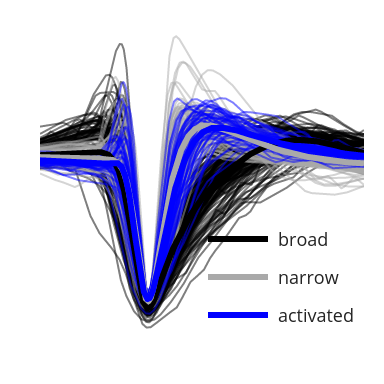

In [152]:
def get_aligned_waveforms(DF):
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])
        centered.append(wave)

    centered = np.stack(centered, axis=0)

    return centered, time

fig = go.Figure()
PHOTOACT = HardBlue
for clss, color in zip(['broad', 'narrow', 'activated'],[Black, DarkGray, PHOTOACT]):
    lines, t = get_aligned_waveforms(toclust.query(f"triple == '{clss}'"))

    # Single waveform examples, decimated,
    decimate = 150
    if lines.shape[0] >= decimate:
        decimator = np.random.choice(lines.shape[0], decimate, replace=False)
        mlines = lines[decimator, :]
    else:
        mlines = lines

    for line in mlines:
        _ = fig.add_trace(
            go.Scatter(x=t, y=line, mode='lines',
                       line=dict(
                           color=add_opacity(color, 1),
                           # color=color,
                                 width=1),
                       opacity=0.5,
                       showlegend=False))


# Average for the group, have to do it second so they are on top
for clss, color in zip(['broad', 'narrow', 'activated'],[Black, DarkGray, HardBlue]):
    lines, t = get_aligned_waveforms(toclust.query(f"triple == '{clss}'"))
    _ = fig.add_trace(
            go.Scatter(x=t, y=lines.mean(axis=0), mode='lines',
                       line=dict(color=color, width=3),
                       name=clss))

#formating
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  xaxis=dict(title=dict(standoff=0,
                                        text=''
                                        ),
                             showticklabels=False,
                             showline=False,
                             ticks='',
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='',

                                        standoff=0,
                                        ),
                             showticklabels=False,
                             showline=False,
                             ticks='',
                             tickfont_size=9),
                  showlegend=True,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0,
                              font_size=9,
                              title_text='',
                              bgcolor="rgba(0,0,0,0)"),
                  )

filename = folder / 'fig5_waveformsd'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

# Example neuron phototagged raster

In [153]:
# to allow longer trials with short pulses, sub in  Trial_LightPulseDuration for Ref_Duration
cellid = 'TNC013a-031-4'
expt_n = 1 # which of the phototag experiments to use
# data time offsets in ms? relative to light on
tstart = -0.02
tend = 0.1

rasterfs = 5000

# find the raw files in the database
df = nd.pd_query("SELECT sCellFile.cellid, sCellFile.stimfile, sCellFile.stimpath, sCellFile.rawid,"
                 "g2.value as Ref_Duration FROM sCellFile "
                 "INNER JOIN gData ON gData.rawid=sCellFile.rawid AND gData.name='TrialObjectClass' "
                 "INNER JOIN gData g2 ON g2.rawid=sCellFile.rawid AND g2.name='Ref_Duration' "
                 "WHERE gData.svalue='RefTarOpt' AND g2.value<0.1 AND sCellFile.RunClassid = 51 "
                 f"AND sCellFile.cellid='{cellid}'") # change this cellid as needed

# clean up DF
df['siteid'] = df.cellid.apply(nd.get_siteid)
df['recording'] = df.stimfile.str.split('.').str[0]
df['parmfile'] = df.stimpath + df.stimfile  # full path to parameter file.
df.drop(columns=['stimfile'], inplace=True)

print(df)

# select just one of multiple phototag experiments for the neuron
paramfile, rawid = df.loc[:, ('parmfile', 'rawid')].iloc[expt_n, :]
manager = BAPHYExperiment(parmfile=paramfile, rawid=rawid,
                          cellid=cellid)

rec = manager.get_recording(recache=True, resp=True, rasterfs=rasterfs, stim=False)
rec['resp'] = rec['resp'].rasterize()
prestim = rec['resp'].extract_epoch('PreStimSilence').shape[-1] / rasterfs

# get light on / off
opt_data = rec['resp'].epoch_to_signal('LIGHTON')
opto_mask = opt_data.extract_epoch('REFERENCE').any(axis=(1, 2))

opt_start_stop_bins = np.argwhere(
    np.diff(opt_data.extract_epoch('REFERENCE')[opto_mask, :, :][0,0,:])).squeeze() + 1
opt_duration = np.diff(opt_start_stop_bins)[0] / rasterfs


rec_cellids = np.asarray(rec['resp'].chans)

# get only the relevant part of the raster, using the light onset time as an anchor point
start_time = prestim + tstart
end_time = prestim + tend
start_bin = np.floor(start_time * rasterfs).astype(int)
end_bin = np.floor(end_time * rasterfs).astype(int)

raw_raster = rec['resp'].extract_epoch('REFERENCE')[:, :, start_bin:end_bin]

ON = raw_raster[opto_mask,0,:]
OFF = raw_raster[~opto_mask,0,:]

t = np.linspace(tstart, tend, end_bin - start_bin, endpoint=False) * 1000 # in ms

[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.m


          cellid                           stimpath   rawid  Ref_Duration  \
0  TNC013a-031-4  /auto/data/daq/Teonancatl/TNC013/  143892          0.02   
1  TNC013a-031-4  /auto/data/daq/Teonancatl/TNC013/  143891          0.02   
2  TNC013a-031-4  /auto/data/daq/Teonancatl/TNC013/  143890          0.02   

    siteid        recording                                           parmfile  
0  TNC013a  TNC013a12_p_NON  /auto/data/daq/Teonancatl/TNC013/TNC013a12_p_N...  
1  TNC013a  TNC013a11_p_NON  /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_N...  
2  TNC013a  TNC013a10_p_NON  /auto/data/daq/Teonancatl/TNC013/TNC013a10_p_N...  


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 120 trials totaling 203.39 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[n

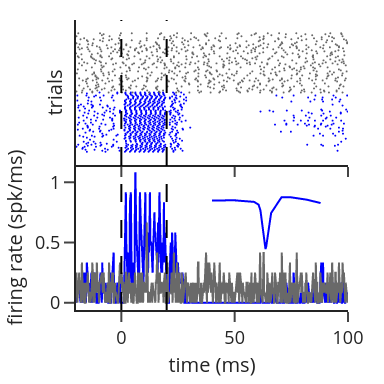

In [154]:
fig = make_subplots(3,1)

for oo, (arr, color) in enumerate(zip([ON, OFF],[PHOTOACT,'#696969'])):
    # spike raster / light onset/offset
    yoffset = (ON.shape[0] - 1) * oo
    st = np.where(arr)
    x = ((st[1] / rasterfs) + tstart) * 1000
    # _ = axes[0].scatter(x, st[0], s=1, color='blue')
    _ = fig.add_trace(go.Scatter(x=x, y= st[0] + yoffset, mode='markers',
                                 marker=dict(color=color, size=1)),
                  row=1,col=1)

    # psth
    y = arr.mean(axis=0) * rasterfs / 1000
    yerr = arr.std(axis=0) / arr.shape[0] * rasterfs
    _ = fig.add_trace(go.Scatter(x=t, y=y, mode='lines', line=dict(color=color, width=1)),
                      row=2,col=1) # last row so it keeps the x axis

# inset of waveform
mean_waveform = toclust.query(f"id == '{cellid}'").waveform_norm.values[0]
x = np.linspace(t[0], t[-1], len(mean_waveform)) # hack to share axes
_ = fig.add_trace(go.Scatter(x=x, y=mean_waveform,
                        mode='lines',
                        line=dict(color=PHOTOACT, width=1)),row=3, col=1)

for row in [1,2]:
    for vline in [0, opt_duration*1000]:
        fig.add_vline(x=vline, line=dict(width=1, dash='dash', color='black'), opacity=1, row=row, col=1)



# format
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  xaxis=dict(matches='x2', autorange=False,
                             showticklabels=False,),
                  yaxis=dict(title=dict(standoff=0,
                                        text='trials',
                                        font_size=10
                                        ),
                             domain=[0.5, 1],
                             showticklabels=False,
                             ticks='',
                             tickfont_size=9),

                  xaxis2=dict(title=dict(standoff=0,
                                         text='time (ms)',
                                         font_size=10
                                         ),
                              range=[-20, 100],
                              tickfont_size=9),
                  yaxis2=dict(title=dict(text='firing rate (spk/ms)',
                                         font_size=10,
                                         standoff=0,
                                         ),
                              domain=[0, 0.5],
                              tickfont_size=9),

                  # inset
                  xaxis3=dict(matches=None,
                              showticklabels=False,
                              ticks='',
                              showline=False,
                              domain=[0.5,0.9]),
                  yaxis3=dict(showticklabels=False,
                              ticks='',
                              showline=False,
                              domain=[0.2, 0.4]),

                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0,
                              font_size=9,
                              title_text='',
                              bgcolor="rgba(0,0,0,0)"),
                  )

filename = folder / 'fig5_eg_phototag'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

# effects by time chunks
lets focus on significant contextual modulation amplitude for chunks A and B, keeping instances that are significant
at any point in time,
furthermore, here we are plotting the delta firing rate independent of significance. however I am only keeping
instances that are significant on the whole duration of the probe.

In [155]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
# metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
metrics = ['integral', 'integral_nosig_A', 'integral_nosig_B', 'integral_nosig_C', 'integral_nosig_D']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' "
                                    )

# now filter the chunks based on the significance of the full probe
DF = pd.merge(DF.query("metric == 'integral' and value > 0").loc[:, ['id', 'context_pair', 'probe']],
              DF.query(f"metric in {[m for m in metrics if m != 'integral']}"),
              on=['id', 'context_pair', 'probe'], validate="1:m" )


DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

DF['chunk'] = DF.metric.str.split('_').str[-1]
DF['metric'] = DF.metric.str.split('_').str[0] + '_non_sig'

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress,
                     # toclust.loc[:,['id', 'phototag', 'phototag2', 'sw_kde', 'triple']],
                     toclust,
                     on='id', validate="m:1").reset_index(drop=True)
print(toregress.shape)
toregress.head()

(183624, 9)
(176564, 28)


,id,context_pair,probe,value,metric,site,region,trans_pair,chunk,grand_mean,...,isolation,spike_type,siteid,phototag,phototag2,phototag3,injected,sw_kde,putative,triple
0,ARM019a-19-7,00_01,1,79.672752,integral_non_sig,ARM019a,PEG,same_silence,A,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
1,ARM019a-19-7,00_01,1,192.542480,integral_non_sig,ARM019a,PEG,same_silence,B,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
2,ARM019a-19-7,00_01,1,53.115166,integral_non_sig,ARM019a,PEG,same_silence,C,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
3,ARM019a-19-7,00_01,1,86.312141,integral_non_sig,ARM019a,PEG,same_silence,D,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
4,ARM019a-19-7,01_04,1,53.115166,integral_non_sig,ARM019a,PEG,diff_same,A,109.018738,...,100.0,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad


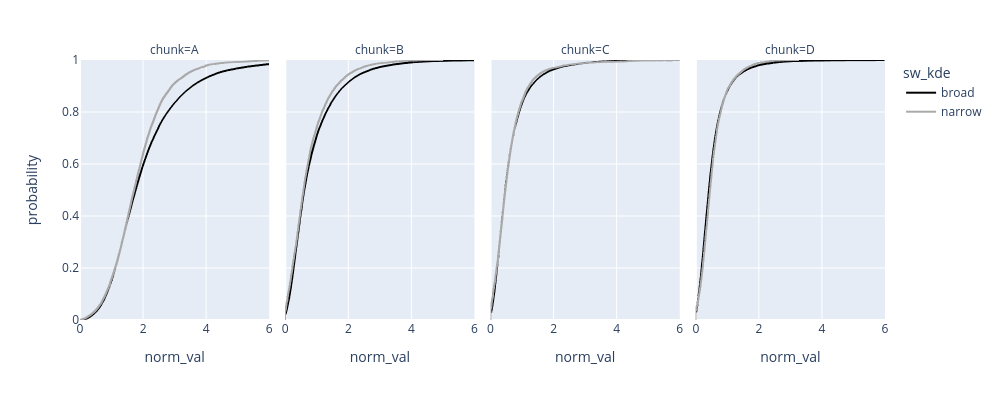

In [156]:
toplot = toregress.dropna(subset='sw_kde')
fig = px.ecdf(toplot.query("sw_kde != 'unclass'"),
              x="norm_val", color='sw_kde', facet_col='chunk',
              color_discrete_map={'narrow': 'darkgray',
                                  'broad': 'black'},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [157]:
for chunk in  toplot.chunk.unique():
    x = toplot.query(f"chunk == '{chunk}' and  sw_kde == 'narrow'").norm_val
    y = toplot.query(f"chunk == '{chunk}' and  sw_kde == 'broad'").norm_val
    stout = sst.ranksums(x, y)
    print(f'{chunk}, {stout}')

# print(toplot.groupby(['chunk','sw_kde']).agg(mean=('norm_val', 'mean')))

A, RanksumsResult(statistic=-8.958408301771708, pvalue=3.293987483708093e-19)
B, RanksumsResult(statistic=-8.3132241175761, pvalue=9.313638591963539e-17)
C, RanksumsResult(statistic=-1.7056992931027823, pvalue=0.08806408135511792)
D, RanksumsResult(statistic=5.747642652329184, pvalue=9.049624215191259e-09)


In [158]:
mod = ols("norm_val ~ C(sw_kde)*C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     8528.
Date:                Sat, 26 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:15:32   Log-Likelihood:            -2.1207e+05
No. Observations:              176564   AIC:                         4.242e+05
Df Residuals:                  176552   BIC:                         4.243e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# phototag

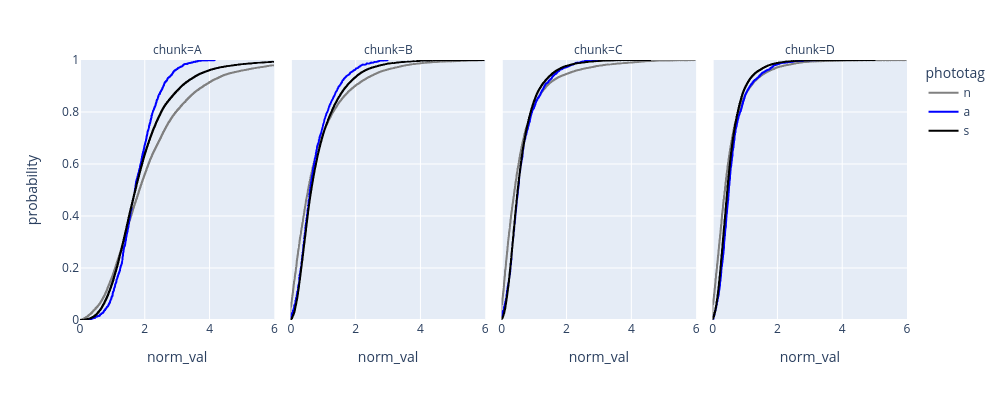

In [159]:
toplot = toregress.dropna(subset='phototag').query("phototag in ['a', 's', 'n']").copy()
toplot['phototag'] = toplot.phototag.cat.remove_unused_categories()
fig = px.ecdf(toplot, x="norm_val", color='phototag', facet_col='chunk',
              color_discrete_map={"a": HardBlue,
                                  "s": "black",
                                  "n": "gray"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [160]:
mod = ols("norm_val ~ C(phototag)*C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     7790.
Date:                Sat, 26 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:15:44   Log-Likelihood:            -1.9487e+05
No. Observations:              161632   AIC:                         3.898e+05
Df Residuals:                  161620   BIC:                         3.899e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## simpliffied categorization
activated, narrow, and broad

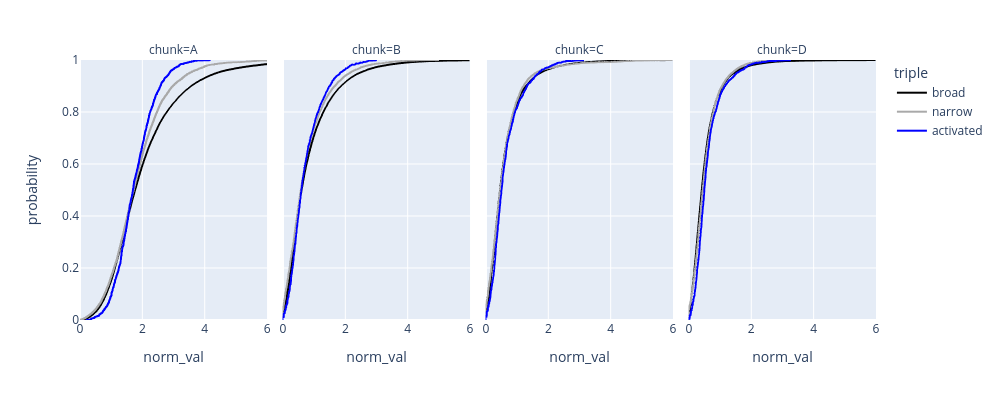

In [161]:
toplot = toregress.dropna(subset='triple').query("triple in ['activated', 'broad', 'narrow']").copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
fig = px.ecdf(toplot, x="norm_val", color='triple', facet_col='chunk',
              color_discrete_map={"activated": PHOTOACT,
                                  "broad": "black",
                                  "narrow": "darkgray"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# back to full duration
since there is nothing particularly interesting for individual time chunks, rater focus on the full length

In [162]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
metrics = ['integral', 'last_bin', 'integral_nosig']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} "
                                    f"and cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' "
                                    f"and analysis == 'SC' "
                                    )

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis',], inplace=True)
DF['metric'] = DF.metric.cat.remove_unused_categories()
DF.reset_index(drop=True, inplace=True)

# use the integrale value to find instances that are significant, and a new significance column
signif_filter = DF.query("metric == 'integral' and value > 0").loc[:,['id', 'context_pair', 'probe']].copy()
signif_filter['significant'] = True

DF = pd.merge(DF, signif_filter, on=['id','context_pair','probe'], how='left', validate='m:1')
DF.loc[DF.significant.isnull(),'significant'] = False
DF['significant'] = DF.significant.astype(bool)


for col in ['id','context_pair','probe','site', 'region', 'metric', 'stim_count']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

DF = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
DF['norm_val'] = DF['value']/DF['grand_mean']
DF.drop(columns=['grand_mean'], inplace=True)

# add celltype labels
toregress = pd.merge(DF,
                     toclust,
                     on='id', validate="m:1").reset_index(drop=True)

print(toregress.shape)
toregress.head()

(1438200, 27)


,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,...,isolation,spike_type,siteid,phototag,phototag2,phototag3,injected,sw_kde,putative,triple
0,ARM019a-03-6,00_01,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
1,ARM019a-03-6,00_02,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
2,ARM019a-03-6,00_03,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
3,ARM019a-03-6,00_04,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
4,ARM019a-03-6,01_02,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad


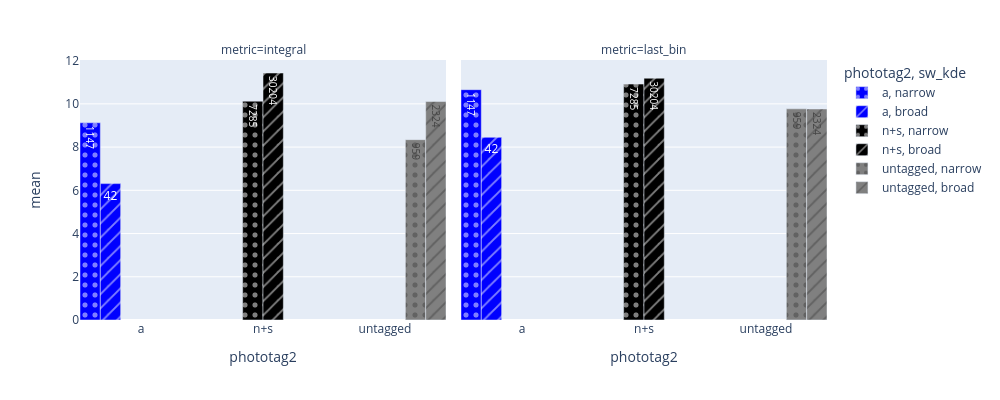

In [163]:
toplot = toregress.query("sw_kde in ['narrow', 'broad'] "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).groupby(['phototag2', 'sw_kde', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()
toplot.dropna(subset='mean', inplace=True)
fig = px.bar(toplot,
             x='phototag2', y='mean', pattern_shape='sw_kde', color='phototag2',
             barmode='group', text='count', facet_col='metric',
             pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
             color_discrete_map={'a': HardBlue, 'n+s': 'black', 'untagged': 'gray'},
             category_orders={'sw_kde': ['narrow', 'broad'],
                              'phototag2': ['a', 'n+s', 'untagged']})

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

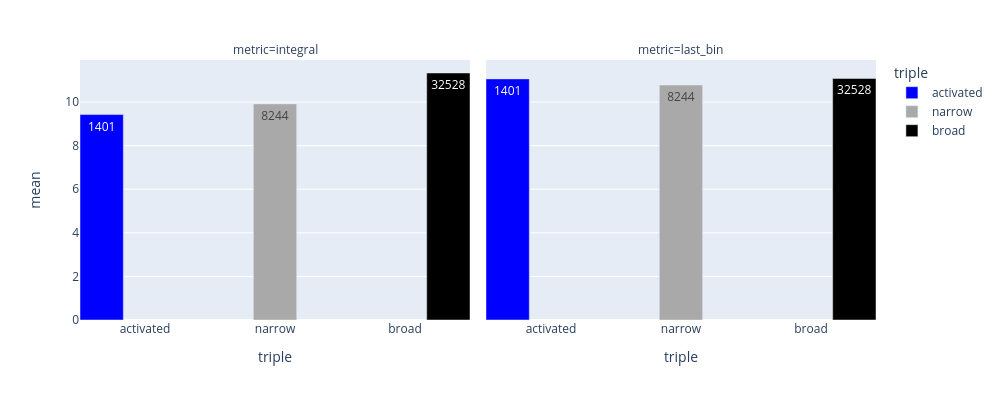

In [164]:
toplot = toregress.query("triple in ['activated', 'narrow', 'broad'] "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()
toplot = toplot.groupby(['triple', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()


fig = px.bar(toplot,
             x='triple', y='mean', color='triple',
             barmode='group', text='count', facet_col='metric',
             # pattern_shape='triple',
             # pattern_shape_map={'narrow': '.', 'activated': '.', 'broad': '/'},
             color_discrete_map={'activated': PHOTOACT, 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              })

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [165]:
import itertools as itt
def all_pairwise_comparison(df, group_col, val_col, statfn):
    stats_df = list()
    for c0, c1 in itt.combinations(df[group_col].unique(), r=2):
        x = df.query(f"{group_col} == '{c0}'")[val_col]
        y = df.query(f"{group_col} == '{c1}'")[val_col]
        stout = statfn(x, y)
        stats_df.append(dict(metric=met, class0=c0, class1=c1,
                             mean0=np.mean(x), mean1=np.mean(y),
                             median0=np.median(x), median1=np.median(y),
                             quant0=np.quantile(x, 0.75), quant1=np.quantile(y, 0.75),
                             pvalue=stout.pvalue))

    stats_df = pd.DataFrame(stats_df).set_index(['metric', 'class0', 'class1'])
    stats_df['corr_pvalue'] = stats_df['pvalue'] * 3
    stats_df['0.05'] = stats_df['corr_pvalue'] < 0.05
    stats_df['0.01'] = stats_df['corr_pvalue'] < 0.01
    stats_df['0.001'] = stats_df['corr_pvalue'] < 0.001
    print(stats_df)
    return stats_df

def kruskal_with_posthoc(df, group_col, val_col):
    # pools data in a list of vectors to run kruskal
    to_stat = list()
    for kk in df[group_col].unique():
        to_stat.append(df.loc[df[group_col] == kk, val_col].values)
    kruskal = sst.kruskal(*to_stat)
    print(kruskal)

    # uses the og dataframe to run the pairwise posthoc test
    dunn = posthoc_dunn(df, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    print(f'Dunn post hoc results\n{dunn}')

    return kruskal, dunn

def jknf(x, njacks= 20, fn=np.mean):
    pred = x
    chunksize = int(np.ceil(len(pred) / njacks / 10))
    chunkcount = int(np.ceil(len(pred) / chunksize / njacks))
    idx = np.zeros((chunkcount, njacks, chunksize))
    for jj in range(njacks):
        idx[:, jj, :] = jj
    idx = np.reshape(idx, [-1])[:len(pred)]
    jc = np.zeros(njacks)
    for jj in range(njacks):
        ff = (idx != jj)
        jc[jj] = fn(pred[ff])

    stat = np.nanmean(jc)
    error = np.nanstd(jc) * np.sqrt(njacks-1)

    return stat, error



######## integral ########
KruskalResult(statistic=63.20672466613851, pvalue=1.8829298015101073e-14)
Dunn post hoc results
           activated         broad        narrow
activated   1.000000  1.059118e-06  1.314109e-01
broad       0.000001  1.000000e+00  1.786963e-10
narrow      0.131411  1.786963e-10  1.000000e+00

######## last_bin ########
KruskalResult(statistic=30.27459544161709, pvalue=2.6665831403429457e-07)
Dunn post hoc results
           activated         broad        narrow
activated   1.000000  2.219481e-01  1.000000e+00
broad       0.221948  1.000000e+00  2.704322e-07
narrow      1.000000  2.704322e-07  1.000000e+00


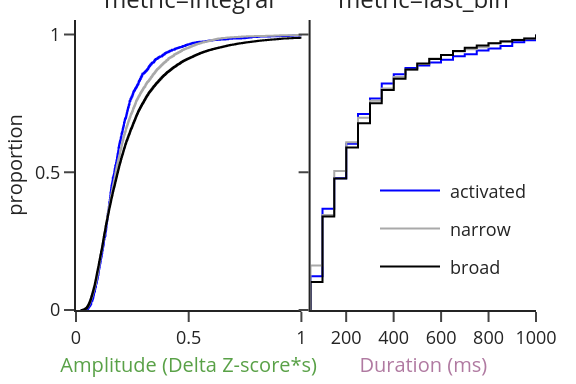

In [166]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', facet_col='metric',
              color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 3, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  xaxis2=dict(matches=None, autorange=True,
                              title=dict(text='Duration (ms)',
                                         font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_context_effect_by_celltype'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

#stats
for met in  toplot.metric.unique():
    print(f"\n######## {met} ########")
    _ = kruskal_with_posthoc(toplot.query(f"metric == '{met}'"), group_col='triple', val_col='value')


img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

In [167]:
toplot.groupby(['metric', 'triple']).agg(count=('value', 'count'), mean=('value', 'mean'))

count        mean
metric         triple                      
integral       activated   1401    0.204019
               broad      32528    0.245317
               narrow      8244    0.214651
integral_nosig activated      0         NaN
               broad          0         NaN
               narrow         0         NaN
last_bin       activated   1401  252.426834
               broad      32528  252.908264
               narrow      8244  246.015289


#### integral ####
             median  SEmedian      mean    SEmean
triple                                           
activated  0.169934  0.005676  0.204019  0.003552
narrow     0.176161  0.002491  0.214651  0.001481
broad      0.185344  0.001026  0.245317  0.001788

#### last_bin ####
           median  SEmedian        mean    SEmean
triple                                           
activated   200.0       0.0  252.426840  5.767985
narrow      150.0       0.0  246.015284  2.032029
broad       200.0       0.0  252.908264  1.833654


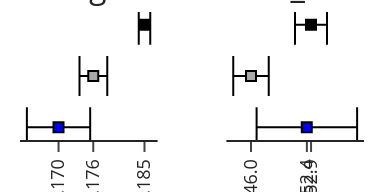

In [168]:
# add someting along the line of means and SEMs
summary = toplot.groupby(['metric', 'triple']).agg(
    median=('value', lambda x: jknf(x, 1000, np.nanmedian)[0]),
    SEmedian=('value', lambda x: jknf(x, 1000, np.nanmedian)[1]),
    mean=('value', lambda x: jknf(x, 1000, np.nanmean)[0]),
    SEmean=('value', lambda x: jknf(x, 1000, np.nanmean)[1]),
)

metrics = ['integral', 'last_bin']
fig = make_subplots(1, 2, horizontal_spacing=0.2, subplot_titles=metrics)
for cc, met in enumerate(metrics):
    met_df = summary.loc[(met), :].reindex(index=['activated', 'narrow', 'broad'])
    print(f"\n#### {met} ####\n{met_df}")
    if met == 'integral':
        stat = met_df['median'].values
        err = met_df['SEmedian'].values
        ticktext = [f'{m:.3f}' for m in stat]
    elif met == 'last_bin':
        stat = met_df['mean'].values
        err = met_df['SEmean'].values
        ticktext = [f'{m:.1f}' for m in stat]
    names = met_df.index.tolist()
    # added line to this single call, make sure it actually works
    fig.add_trace(go.Scatter(x=stat, y=names,
                             mode='markers',
                             opacity=1,
                             showlegend=False,
                             marker=dict(color=[PHOTOACT, DarkGray, Black],
                                         symbol='square',
                                         size=5,
                                         line=dict(color='black',
                                                   width=1)
                                         ),
                             error_x=dict(array=err,
                                          color='black',
                                          thickness=1,
                                          width=10
                                          ),
                             ), row=1, col=cc+1)
    fig.update_xaxes(tickmode='array',
                     tickvals=stat,
                     ticktext=ticktext,
                     tickangle=-90,
                     row=1, col=cc+1)

# formating
w, h = 2, 1
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,)

# commong features of both x axes
fig.update_yaxes(showticklabels=False, ticks='', showline=False,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

fig.update_xaxes(showticklabels=True, ticks='outside', showline=True,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_ctx_effect_inset'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

### injected vs not injected

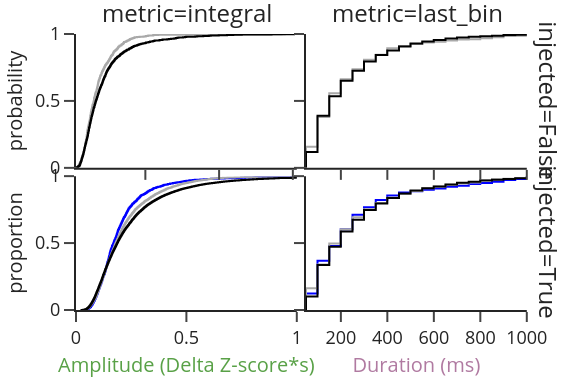

In [169]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', facet_col='metric', facet_row='injected',
              color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
del(toplot)
_ = fig.update_traces(line_width=1)

# formating
w, h = 3, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  xaxis2=dict(matches=None, autorange=True,
                              title=dict(text='Duration (ms)',
                                         font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(matches=None, title=dict(font_size=10, standoff=0), tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9,
                 range=[0,1])

# filename = folder / 'fig5_context_effect_by_celltype'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

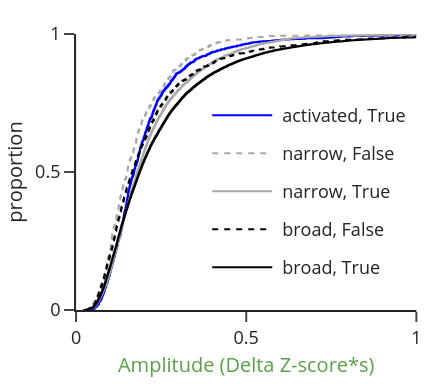

In [170]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric == 'integral'"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', line_dash='injected',
              line_dash_sequence={True:'solid', False:'dot'},
              color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 2.3,2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  # showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  # xaxis2=dict(matches=None, autorange=True,
                  #             title=dict(text='Duration (ms)',
                  #                        font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(matches=None, title=dict(font_size=10, standoff=0), tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9,
                 range=[0,1])

filename = folder / 'fig5_injection_effect'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

In [171]:
mod = quantreg("norm_val ~ C(injected)", toplot.query("metric == 'integral'"))
res = mod.fit(q=0.75)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               norm_val   Pseudo R-squared:             0.002031
Model:                       QuantReg   Bandwidth:                      0.6983
Method:                 Least Squares   Sparsity:                        30.81
Date:                Sat, 26 Nov 2022   No. Observations:                42173
Time:                        13:16:08   Df Residuals:                    42171
                                        Df Model:                            1
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.3769      0.233     48.863      0.000      10.921      11.833
C(injected)[T.True]     2.0611      0.242      8.501      0.000       1.586       2.536


In [172]:
mod = ols("norm_val ~ C(triple)", toplot.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     106.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           8.58e-47
Time:                        13:16:08   Log-Likelihood:            -1.5192e+05
No. Observations:               42173   AIC:                         3.039e+05
Df Residuals:                   42170   BIC:                         3.039e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.4249    

## non singificant
same as above but considering integral regardless of significance.
what thise somehow bring into the plot the proportion of significance instances per group,
but obscures the group differences in  the actual significant contextual effects

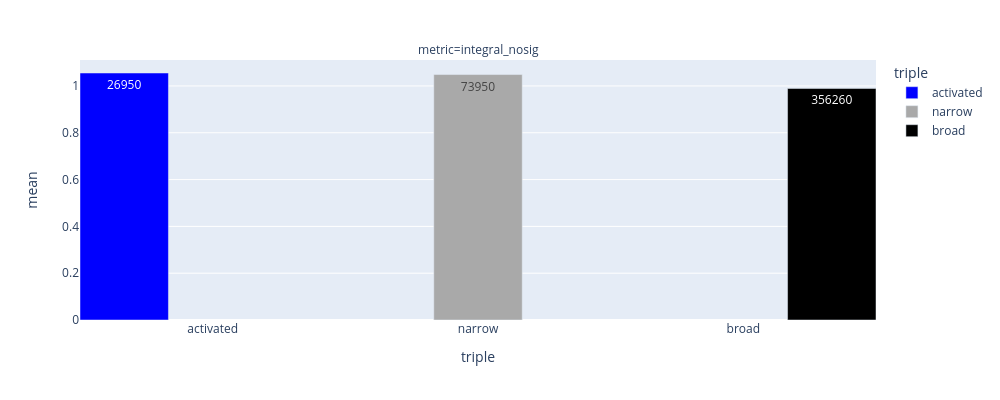

In [173]:
toplot = toregress.query("triple in ['activated', 'narrow', 'broad'] "
                         "and metric in ['integral_nosig']"
                         # "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()
toplot = toplot.groupby(['triple', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()


fig = px.bar(toplot,
             x='triple', y='mean', color='triple',
             barmode='group', text='count', facet_col='metric',
             # pattern_shape='triple',,
             # pattern_shape_map={'narrow': '.', 'activated': '.', 'broad': '/'},
             color_discrete_map={'activated': PHOTOACT, 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              })

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

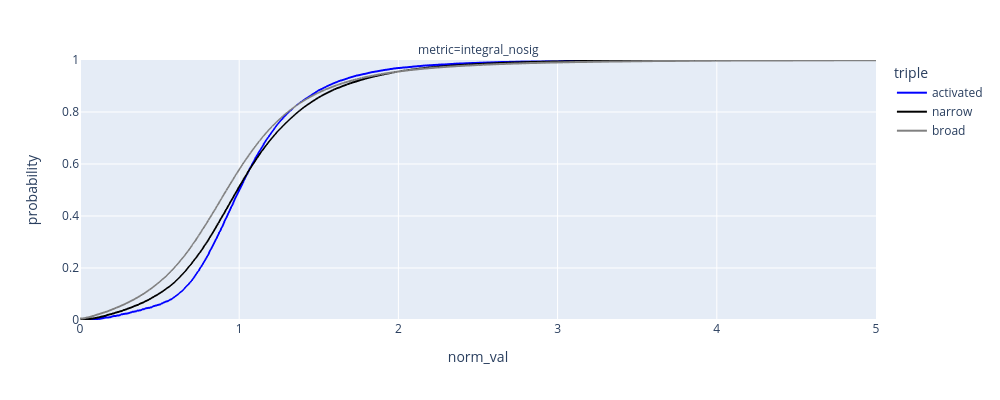

In [174]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral_nosig']"
                         # "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='norm_val', color='triple', facet_col='metric',
              color_discrete_map={'activated': PHOTOACT, 'narrow': 'black', 'broad': 'gray'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               })

fig.update_layout(bargap=0.0, bargroupgap=0.0,
                  xaxis_range=[0, 5],
                  yaxis_range=[0, 1])

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [175]:
import itertools as itt
df = list()
for met in  toplot.metric.unique():
    for c0, c1 in itt.combinations(toplot.triple.unique(),r=2):
        x = toplot.query(f"metric == '{met}' and  triple == '{c0}'").value
        y = toplot.query(f"metric == '{met}' and  triple == '{c1}'").value
        stout = sst.ranksums(x, y)
        df.append(dict(metric=met, class0=c0, class1=c1,
                       mean0=np.mean(x), mean1=np.mean(y), pvalue=stout.pvalue))
        # print(f'{met} {c0} vs {c1}, {stout}')

df = pd.DataFrame(df)
df['significant'] = df['pvalue'] < 0.05/df.shape[0]
df

,metric,class0,class1,mean0,mean1,pvalue,significant
0,integral_nosig,broad,narrow,256.555939,271.972443,0.000000e+00,True
1,integral_nosig,broad,activated,256.555939,273.676758,1.338554e-270,True
2,integral_nosig,narrow,activated,271.972443,273.676758,4.553409e-11,True


# check proportion
what number of significant instances per category? is there a greater likelyhood of showing contextual
effects for inhibitory or pyramidal neurons?


####### non parametric anova with posthoc #######
KruskalResult(statistic=7.41797435090606, pvalue=0.02450232726699855)
Dunn post hoc results
           activated     broad    narrow
activated   1.000000  1.000000  0.235344
broad       1.000000  1.000000  0.022503
narrow      0.235344  0.022503  1.000000


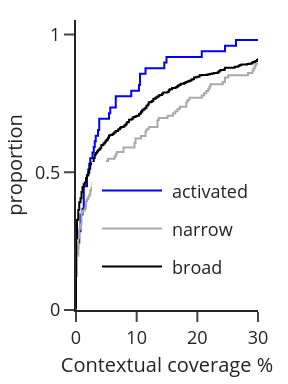

In [176]:
coverage_prop = toregress.query(
    "triple in ['activated', 'narrow', 'broad'] "
    "and metric == 'integral' "
    "and stim_count in [10]" # only select this subsets as is the one containing the optotagged neurons
).groupby(
    ['triple','id'], observed=True
).agg(
    coverage=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

# midpoint statistics
# print("\n####### all pairwise ranksum #######")
# _ = all_pairwise_comparison(coverage_prop, 'triple', 'coverage', sst.ranksums)

print("\n####### non parametric anova with posthoc #######")
_ = kruskal_with_posthoc(coverage_prop, 'triple', 'coverage')


fig = px.ecdf(coverage_prop,
              x='coverage', color='triple',
              color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 1.5, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0,30],
                             title=dict(text='Contextual coverage %')),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_coverage_by_celltype'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)


##### bar values #####
           coverage     error
triple                       
activated  2.000000  0.626680
narrow     3.916364  1.105458
broad      2.148182  0.595277


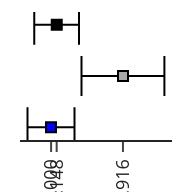

In [177]:
coverage_summary = coverage_prop.groupby(
    ['triple'], observed=True
).agg(
    coverage=('coverage', lambda x: jknf(x, 100, np.median)[0]),
    error=('coverage', lambda x: jknf(x, 100, np.median)[1]),
).reindex(index=['activated', 'narrow', 'broad'])

print(f"\n##### bar values #####\n{coverage_summary}")

fig = go.Figure()

stat = coverage_summary['coverage'].values
err = coverage_summary['error'].values
names = coverage_summary.index.tolist()
# added line to this single call, make sure it actually works
fig.add_trace(go.Scatter(x=stat, y=names,
                         mode='markers',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color=[PHOTOACT, DarkGray, Black],
                                     symbol='square',
                                     size=5,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_x=dict(array=err,
                                      color='black',
                                      thickness=1,
                                      width=10
                                      ),
                         ))

fig.update_xaxes(tickmode='array',
                 tickvals=stat,
                 ticktext=[f'{m:.3f}' for m in stat],
                 tickangle=-90
                 )

# formating
w, h = 1, 1
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,)

# commong features of both x axes
fig.update_yaxes(showticklabels=False, ticks='', showline=False,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

fig.update_xaxes(showticklabels=True, ticks='outside', showline=True,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_coverage_inset'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

      triple  injected  sig_prcnt   count
0      broad     False   0.303030    1650
1      broad      True   8.950156  336050
2  activated      True   5.198516   26950
3     narrow     False   0.242424    3300
4     narrow      True  11.214734   63800


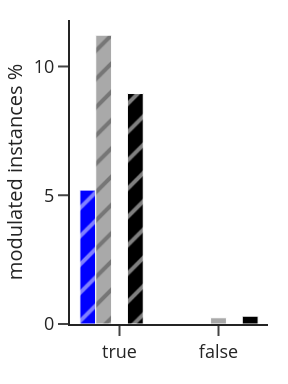

In [113]:
# split by injection or not

sig_prop = toregress.query(
    "triple in ['activated', 'narrow', 'broad'] "
    "and metric == 'integral' "
    "and stim_count in [10]" # compare pears and pears. the only injected sites where 10-sounds
).groupby(
    ['triple', 'injected'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

sig_prop['triple'] = sig_prop['triple'].cat.remove_unused_categories()
print(sig_prop)
fig = px.bar(sig_prop,
             x='injected', pattern_shape='injected',
             y='sig_prcnt', color='triple',
             barmode='group',
             # text='count',
             pattern_shape_map={True: '/', False: ''},
             color_discrete_map={'activated': PHOTOACT, 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              'injected': [True, False]}
             )

# formating
w, h = 1.5, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None,
                             title_text=None,
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='modulated instances %', font_size=10, standoff=0),
                             tickfont_size=9),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_percent_modulated_by_injection'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

# Firing rate
since firing rate has a small effect on contextthere is a slim chance that firing rate will ha

In [114]:
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220901_raw_fr_by_instance' # zscored firing rate
fr_DF = jl.load(fr_DF_file)

# simply takes the cell mean firing rate across all contexts, probes, and pupil sizes
fr_DF = fr_DF.query("chunk == 'full' and pupil == 'full' and part == 'probe' and metric == 'firing_rate'"
                  ).groupby(['id'], observed=True).agg(FR=('value', 'mean')).reset_index()

print(fr_DF.shape)
print(fr_DF.head())

(1669, 2)
             id        FR
0  AMT020a-02-1  1.771375
1  AMT020a-04-1  0.437125
2  AMT020a-07-1  0.008250
3  AMT020a-08-1  0.359875
4  AMT020a-13-1  0.196000


In [115]:
fr_cls_DF = pd.merge(fr_DF, toclust, on=['id'], validate="1:1")

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


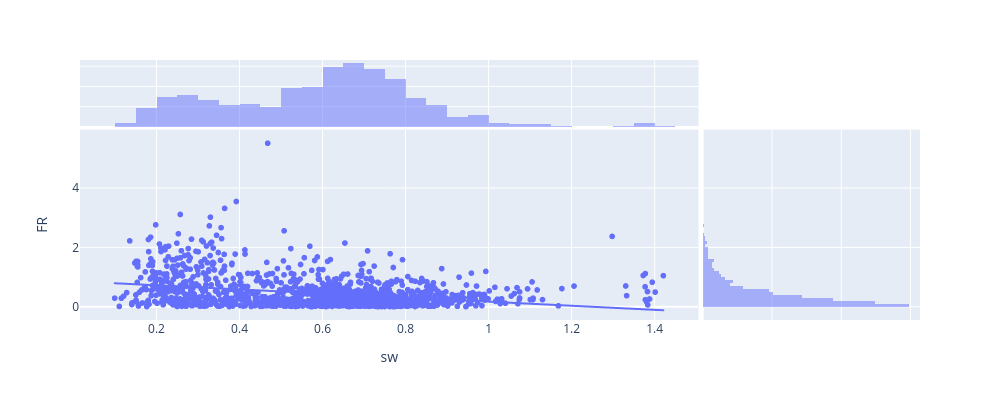

In [116]:
fig = px.scatter(fr_cls_DF, y='FR', x='sw', trendline='ols', marginal_x='histogram', marginal_y='histogram')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


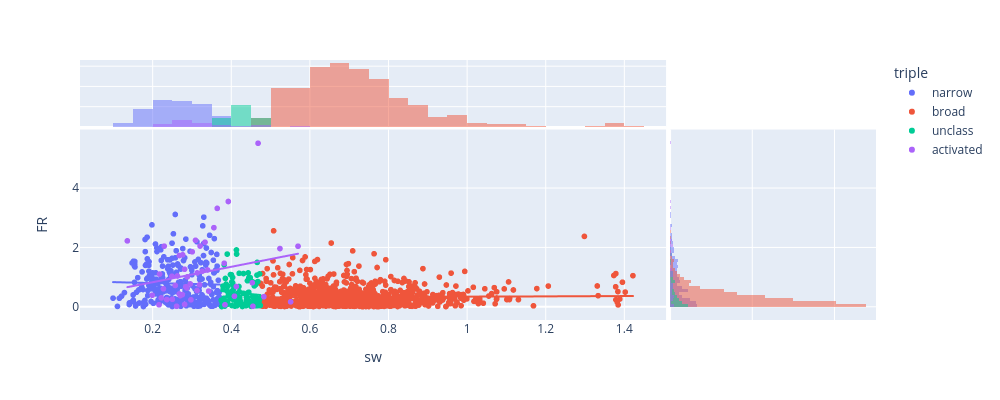

In [117]:
fig = px.scatter(fr_cls_DF, y='FR', x='sw',
                 color='triple',
                 trendline='ols', marginal_x='histogram', marginal_y='histogram')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


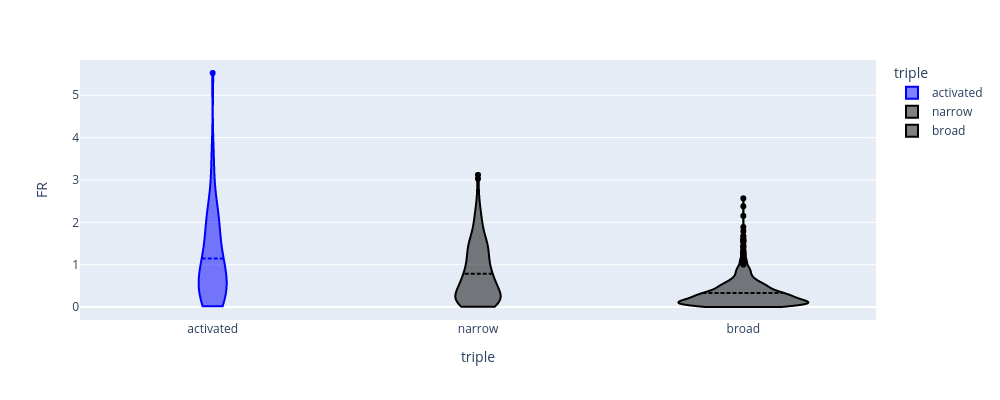

In [118]:
fig = px.violin(fr_cls_DF.query("triple != 'unclass'"),
                y='FR', x='triple', color='triple',
                color_discrete_map={'activated': PHOTOACT, 'narrow': 'black', 'broad': 'black'},
                category_orders={'triple': ['activated', 'narrow', 'broad']},
                )
fig.update_traces(meanline_visible=True,
                  # marker_size=2,
                  # points='outliers',
                  # jitter=0.1,
                  # scalemode='width',
                  spanmode='hard')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

In [119]:
mod = ols("FR ~ C(triple)", data=fr_cls_DF.query("triple != 'unclass'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     FR   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     160.1
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           6.27e-63
Time:                        13:13:35   Log-Likelihood:                -849.29
No. Observations:                1316   AIC:                             1705.
Df Residuals:                    1313   BIC:                             1720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1474 

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning:

divide by zero encountered in double_scalars



## FR vs Percent Significant
this is not in

In [120]:
sig_prcnt_DF = DF.query(
    "metric == 'integral'"
).groupby(
    ['stim_count', 'id'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()
print(sig_prcnt_DF.shape)
print(sig_prcnt_DF.head())

(1722, 4)
  stim_count            id  sig_prcnt  count
0          4  ARM019a-03-6       10.0     40
1          4  ARM019a-06-5        5.0     40
2          4  ARM019a-07-6       50.0     40
3          4  ARM019a-10-5        7.5     40
4          4  ARM019a-10-6        0.0     40


In [121]:
fr_sig_DF = pd.merge(fr_DF, sig_prcnt_DF, on=['id'], validate="1:1")

LinregressResult(slope=7.302760528245109, intercept=8.230659208699274, rvalue=0.23826190295091113, pvalue=5.67402521944779e-23, stderr=0.7290775869784075, intercept_stderr=0.4899779507499946)


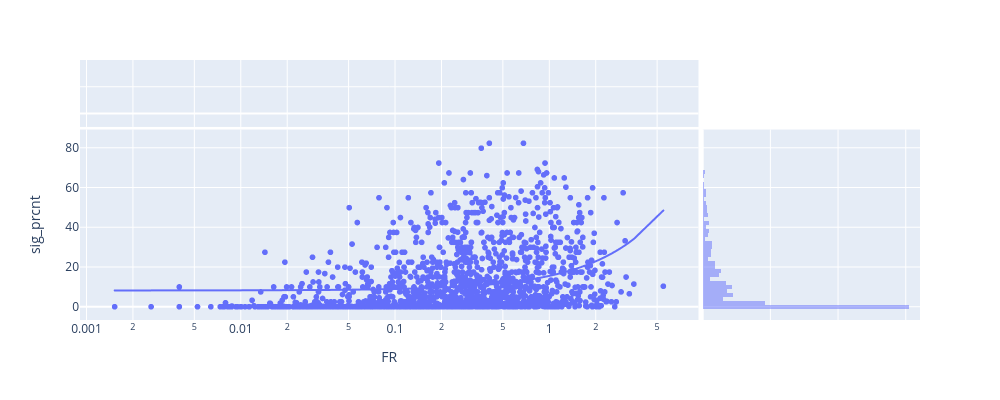

In [122]:
fig = px.scatter(fr_sig_DF, x='FR', y='sig_prcnt', trendline='ols',
                 log_x=True,
                 marginal_x='histogram', marginal_y='histogram')

print(sst.linregress(x=fr_sig_DF.FR,y=fr_sig_DF.sig_prcnt))
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [123]:
# define a set of bins for the long firing rate
fr_DF['logFR'] = np.log10(fr_DF['FR'])
q = 9
fr_DF['quant'] = pd.qcut(fr_DF['logFR'],q, labels=list(range(q)))

In [124]:
toplot = pd.merge(toregress.query("metric =='integral' and significant and triple != 'unclass'"),
                  fr_DF.reset_index(), on='id', validate='m:1')
toplot.head()

,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,...,phototag2,phototag3,injected,sw_kde,putative,triple,index,FR,logFR,quant
0,ARM019a-03-6,00_03,3,348.194641,integral,ARM019a,PEG,4,True,16.085339,...,untagged,False,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
1,ARM019a-03-6,01_03,3,560.980286,integral,ARM019a,PEG,4,True,25.915268,...,untagged,False,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
2,ARM019a-03-6,02_03,3,367.538818,integral,ARM019a,PEG,4,True,16.978970,...,untagged,False,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
3,ARM019a-03-6,03_04,3,444.915405,integral,ARM019a,PEG,4,True,20.553490,...,untagged,False,False,broad,pyramidal,broad,252,0.016375,-1.785819,0
4,ARM019a-06-5,01_03,1,389.830322,integral,ARM019a,PEG,4,True,18.008757,...,untagged,False,False,narrow,inhibitory,narrow,253,0.158125,-0.800999,3


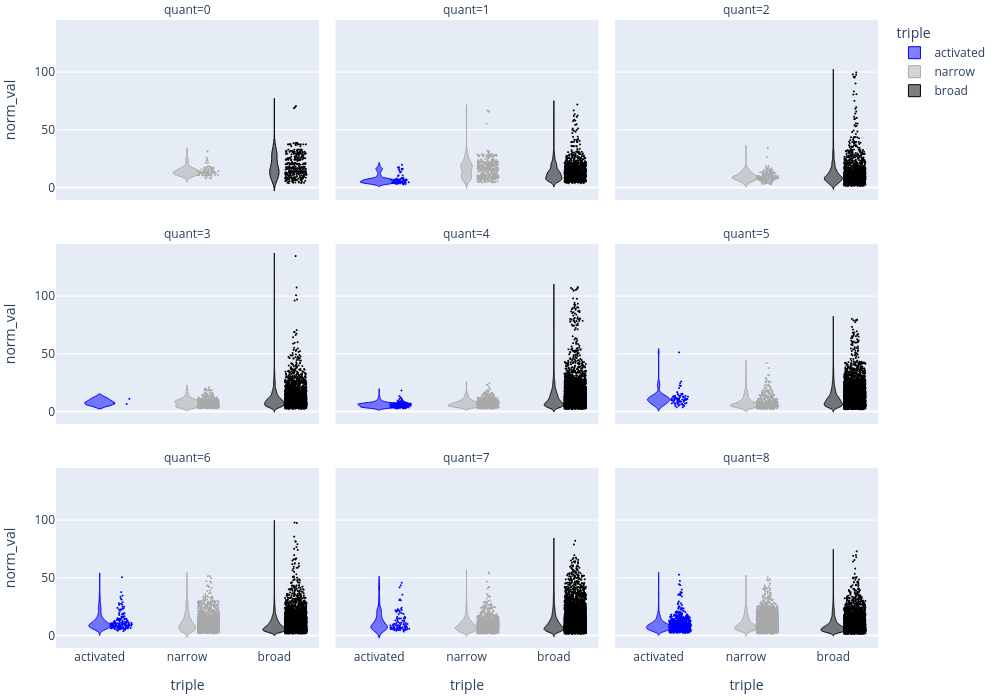

In [125]:
fig = px.violin(toplot, x='triple', y='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': PHOTOACT, 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )
fig.update_traces(marker_size=2,
                  points='all',
                  pointpos=1,
                  jitter=0.5,
                  line_width=1,
                  scalemode='width')

fig.update_layout(margin=dict(t=20, b=10, l=10, r=10),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=700)
Image(img_bytes)

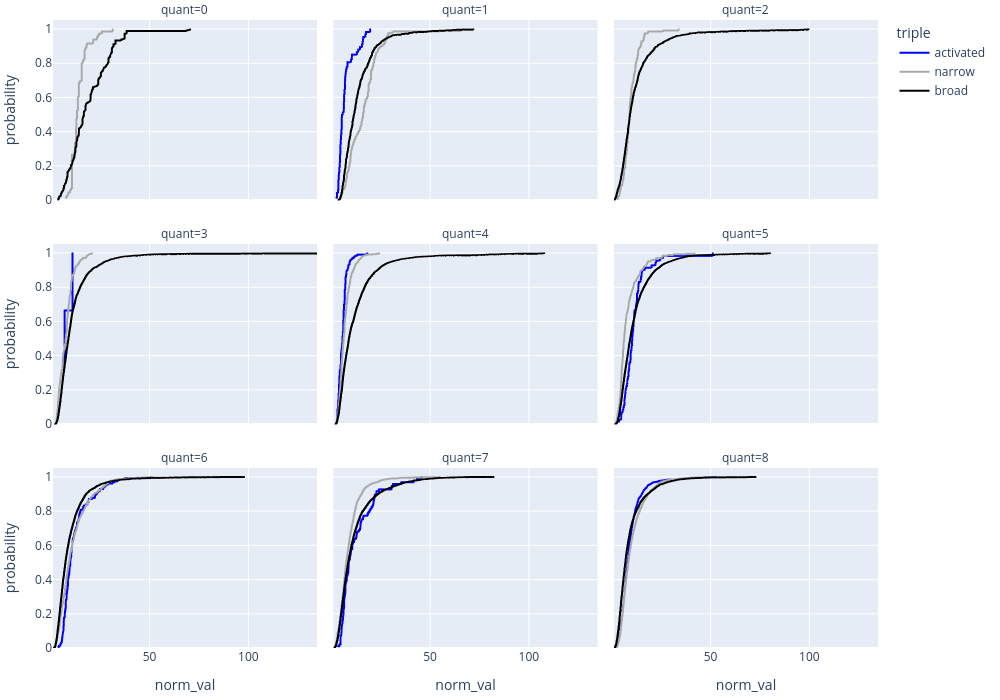

In [126]:
fig = px.ecdf(toplot, x='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': PHOTOACT, 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )
fig.update_layout(margin=dict(t=20, b=10, l=10, r=10),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=700)
Image(img_bytes)

In [127]:
df = list()
for qq in toplot.quant.unique():
    mod = quantreg("norm_val ~ C(triple)", toplot.query(f"quant == {qq}"))
    res = mod.fit(q=0.75)

    # print(res.summary())
    ww = res.params
    ww.name = f'params'

    pp = res.pvalues
    pp.name = f'pvalues'

    out = pd.concat([ww, pp], axis=1)
    out.drop(index=['C(triple)[T.unclass]'], inplace=True)
    # out.rename(index={'Intercept':'activated','C(triple)[T.broad]': 'broad', 'C(triple)[T.narrow]':'narrow'},
    #            inplace=True)
    out['quant'] = qq
    df.append(out)
df = pd.concat(df)

df['significant'] = df['pvalues'] < (0.05 / df.shape[0])
df.reset_index(inplace=True)
df = df.sort_values(by=['quant', 'index'], ascending=[True, True], ignore_index=True)
df.set_index(['quant', 'index'], inplace=True)
print(df)

                              params        pvalues  significant
quant index                                                     
0     C(triple)[T.broad]   11.979324   1.234756e-54         True
      C(triple)[T.narrow]   1.842116   5.962858e-02        False
      Intercept            13.821440   7.185216e-90         True
1     C(triple)[T.broad]    9.192478   1.438205e-10         True
      C(triple)[T.narrow]  12.791078   7.032932e-17         True
      Intercept             7.331982   1.378911e-07         True
2     C(triple)[T.broad]    5.484997   1.659893e-51         True
      C(triple)[T.narrow]   3.110739   1.953809e-07         True
      Intercept             8.595735  5.938267e-141         True
3     C(triple)[T.broad]    2.123174   7.371438e-01        False
      C(triple)[T.narrow]  -1.318981   8.352272e-01        False
      Intercept            10.939832   8.367923e-02        False
4     C(triple)[T.broad]    8.187277   2.444959e-19         True
      C(triple)[T.narrow]

In [128]:
ww = res.params
ww.name = f'params'

pp = res.pvalues
pp.name = f'pvalues'

out = pd.concat([ww, pp], axis=1)
out.drop(index=['C(triple)[T.unclass]'], inplace=True)
out.rename(index={'Intercept':'activated','C(triple)[T.broad]': 'broad', 'C(triple)[T.narrow]':'narrow'},
           inplace=True)
out['quant'] = qq
out

,params,pvalues,quant
activated,14.094952,9.652960e-54,6
broad,-2.189528,1.714625e-02,6
narrow,0.189949,8.420640e-01,6


# list of CPN sites to phototag
nothing special, just to keep track of it

In [129]:
all_proc_sites = set(get_phototags().siteid)

all_opto_sites={'ARM004e', 'TNC006a', 'TNC008a', 'TNC009a', 'TNC010a', 'TNC011a',
       'TNC012a', 'TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a',
       'TNC018a', 'TNC019a', 'TNC020a', 'TNC021a', 'TNC022a', 'TNC023a',
       'TNC024a', 'TNC029a', 'TNC043a', 'TNC044a', 'TNC045a', 'TNC047a',
       'TNC048a', 'TNC049a', 'TNC050a', 'TNC051a', 'TNC062a', 'CLT027c',
       'CLT028c', 'CLT031c', 'CLT032c', 'CLT033c', 'CLT034c', 'CLT035c',
       'CLT036c', 'CLT037c', 'CLT038a', 'CLT039c', 'CLT040c', 'CLT041c',
       'CLT042a', 'CLT043b', 'CLT044d', 'CLT045d', 'CLT048c', 'CLT049c'}

all_ctx_sites= set(DF.site.unique())


all_unproc = set(all_opto_sites).difference(set(all_proc_sites))
ctx_unproc = all_unproc.intersection(set(all_ctx_sites))
ctx_unproc

set()